# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 4</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

from pyclustertend import hopkins
from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import Image
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

In [4]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
viviendas_caba_test=pd.read_csv('./Datasets/viviendas_caba_test.csv').copy()
viviendas_caba=pd.read_csv('./Datasets/viviendas_caba.csv').copy()

pca_df=pd.read_csv('./Datasets/pca_properati_argentina_2021.csv').copy()

poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 2. Regresión

## Modelo 1: KNN

### Dataset completo:

#### Eleccion de variables regresoras

Como en el parte 1 ya limpiamos los valores atípicos no tenemos que hacerlo nuevamente para esta parte

**Realizamos Encoding**

para variable property_type y barrio

In [5]:
viviendas_caba_encoded = viviendas_caba.copy()
viviendas_caba_encoded['property_type'] = LabelEncoder().fit_transform(viviendas_caba['property_type'])
viviendas_caba_encoded['barrio'] = LabelEncoder().fit_transform(viviendas_caba['barrio'])
viviendas_caba_encoded.head(2)

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry
0,2021-09-09,2021-09-26,-34.637319,-58.361124,7,1,3.0,2.0,58.0,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,POINT (-58.361124 -34.6373187)
1,2021-09-09,2021-09-28,-34.628647,-58.361871,7,1,4.0,3.0,70.0,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,POINT (-58.3618713 -34.6286465)


In [157]:
"""pairplot_viviendas_caba_encoded= sns.pairplot(viviendas_caba_encoded).figure
pairplot_viviendas_caba_encoded.savefig('./Figures/pairplot_viviendas_caba_encoded')"""

"pairplot_viviendas_caba_encoded= sns.pairplot(viviendas_caba_encoded).figure\npairplot_viviendas_caba_encoded.savefig('./Figures/pairplot_viviendas_caba_encoded')"

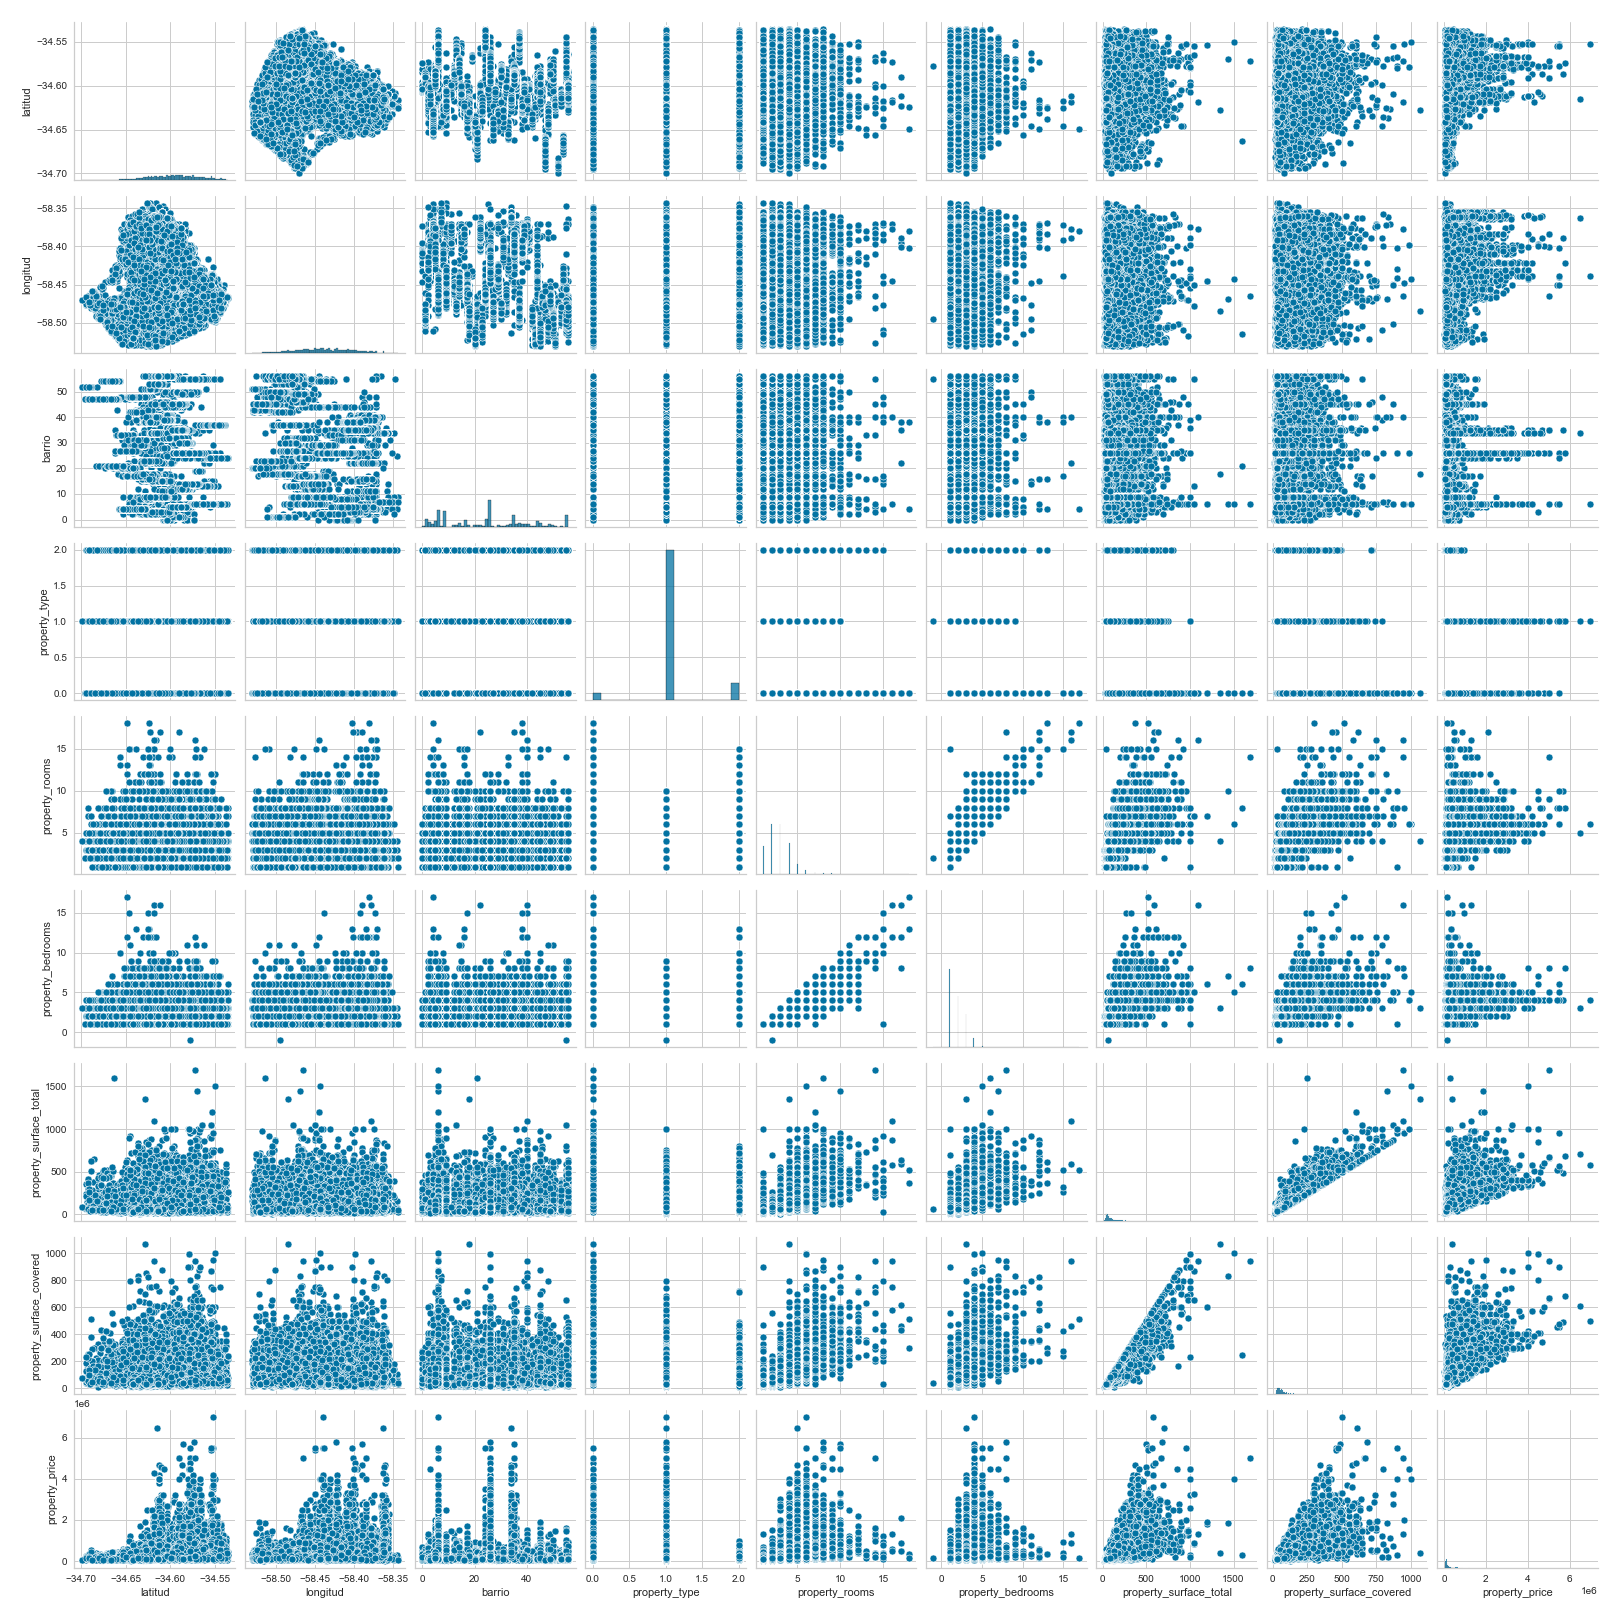

In [158]:
Image(filename = './Figures/pairplot_viviendas_caba_encoded.png', width=1000, height=1000)

In [7]:
#Heatmap correlación
viviendas_caba_encoded.corr().style.background_gradient(cmap='coolwarm')

C:\Users\chulo\AppData\Local\Temp\ipykernel_22916\3059277274.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  viviendas_caba_encoded.corr().style.background_gradient(cmap='coolwarm')


,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.141103,0.016952,-0.065060,-0.026360,-0.028009,0.021501,0.040684,0.165261
longitud,-0.141103,1.000000,-0.254398,-0.073198,0.009903,0.007454,-0.004242,0.047954,0.126130
barrio,0.016952,-0.254398,1.000000,0.037220,-0.017533,-0.022601,0.016797,0.000657,-0.005310
property_type,-0.065060,-0.073198,0.037220,1.000000,-0.065310,-0.072324,-0.170745,-0.198191,-0.132513
property_rooms,-0.026360,0.009903,-0.017533,-0.065310,1.000000,0.926325,0.757079,0.770356,0.523442
property_bedrooms,-0.028009,0.007454,-0.022601,-0.072324,0.926325,1.000000,0.724889,0.736133,0.483020
property_surface_total,0.021501,-0.004242,0.016797,-0.170745,0.757079,0.724889,1.000000,0.954240,0.723027
property_surface_covered,0.040684,0.047954,0.000657,-0.198191,0.770356,0.736133,0.954240,1.000000,0.776274
property_price,0.165261,0.126130,-0.005310,-0.132513,0.523442,0.483020,0.723027,0.776274,1.000000


**Correlación**

Gracias al pairplot y a la matriz de correlación vemos que el precio está más relacionado con la superficie total y cubierta, seguidas por property_rooms y property_bedrooms. Inicialmente elegimos a ambas superficies como variables regresoras para property_price, pero luego nos dimos cuenta que agregando rooms y bedrooms mejoraban nuestras métricas.

In [8]:
#selecciono variables regresoras y a predecir
X_train_knn = viviendas_caba_train[['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']]
X_test_knn = viviendas_caba_test[['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']]

y_train_knn = viviendas_caba_train.property_price
y_test_knn= viviendas_caba_test.property_price

In [9]:
#Heatmap correlación
X_train_knn.corr().style.background_gradient(cmap='coolwarm')

,property_surface_total,property_surface_covered,property_rooms,property_bedrooms
property_surface_total,1.000000,0.954711,0.758225,0.726663
property_surface_covered,0.954711,1.000000,0.771415,0.737603
property_rooms,0.758225,0.771415,1.000000,0.926374
property_bedrooms,0.726663,0.737603,0.926374,1.000000


<AxesSubplot:xlabel='property_surface_total', ylabel='property_price'>

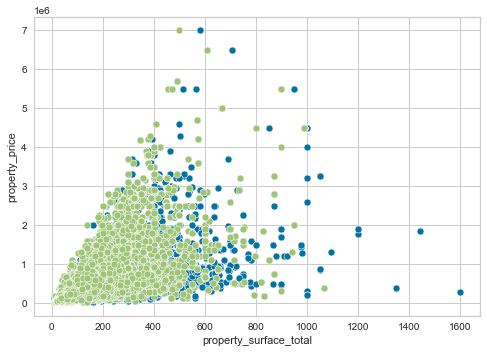

In [162]:
sns.scatterplot(x=X_train_knn.property_surface_total,y=y_train_knn)
sns.scatterplot(x=X_train_knn.property_surface_covered,y=y_train_knn)

#### Ingeniería de características

**Normalizado de datos**

Decidimos no normalizar ya que empeoraban levemente nuestras métricas.

In [163]:
"""from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#scalling the training set
X_train_knn = sc.fit_transform(X_train_knn)
#scalling the test set
X_test_knn = sc.fit_transform(X_test_knn)"""

'from sklearn.preprocessing import StandardScaler\n\nsc = StandardScaler()\n#scalling the training set\nX_train_knn = sc.fit_transform(X_train_knn)\n#scalling the test set\nX_test_knn = sc.fit_transform(X_test_knn)'

In [164]:
"""from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.fit_transform(X_test_knn)"""

'from sklearn.preprocessing import MinMaxScaler\n\nscaler = MinMaxScaler() \nX_train_knn = scaler.fit_transform(X_train_knn)\nX_test_knn = scaler.fit_transform(X_test_knn)'

**Optimizamos los parámetros usando random search cross validation**

In [10]:


#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn_regressor=KNeighborsRegressor()

#Random Search con 5 Folds y 5 iteraciones
rand_knn = RandomizedSearchCV(knn_regressor, params_grid, cv=5, scoring='r2', n_iter=5, random_state=5)

rand_knn.fit(X_train_knn, y_train_knn)
rand_knn.cv_results_['mean_test_score']

array([0.7369784 , 0.6675903 , 0.74332207, 0.68320021, 0.71345545])

In [11]:
#Mejores hiperparametros
print(rand_knn.best_params_)
#Mejor métrica
print(rand_knn.best_score_)

{'weights': 'distance', 'n_neighbors': 27, 'metric': 'euclidean', 'algorithm': 'kd_tree'}
0.7433220739268783


#### Métricas sobre train

In [12]:
#Mejor estimador
best_knn_regressor = rand_knn.best_estimator_

#Predicción con mejor estimador
y_pred_train_knn = best_knn_regressor.predict(X_train_knn)

#Coef. de Determinación R2

print(f'Coef. de Determinación R2: {r2_score(y_train_knn, y_pred_train_knn)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train_knn,
        y_pred  = y_pred_train_knn,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train_knn,
        y_pred  = y_pred_train_knn,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9493873643633576
El error (mse) de test es: 4421151058.016585
El error (rmse) de test es: 66491.7367649288


In [13]:
# Performance
performance_train = pd.DataFrame({'Valor Real': y_train_knn,
                            'Prediccion': y_pred_train_knn.round(),
                            'Error': y_train_knn - y_pred_train_knn.round()})
# View
performance_train.head()

,Valor Real,Prediccion,Error
0,167113.0,139250.0,27863.0
1,129000.0,120311.0,8689.0
2,124600.0,202711.0,-78111.0
3,196000.0,130304.0,65696.0
4,235000.0,168370.0,66630.0


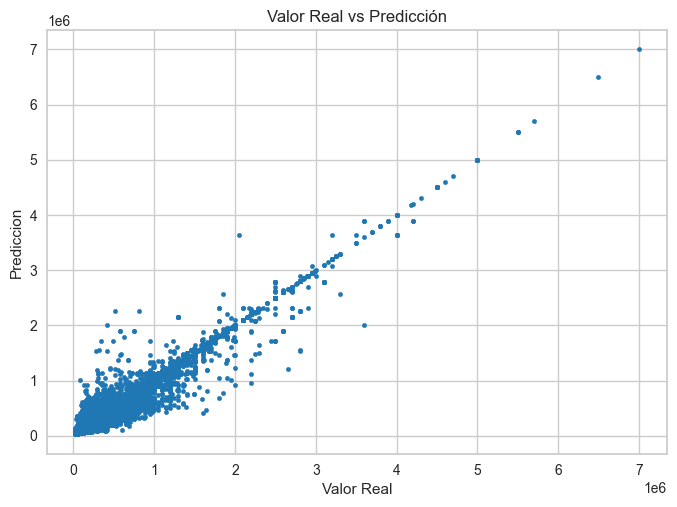

In [14]:
scatter_real_predict_train = performance_train.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


#### Métricas sobre test 

In [15]:
#Predicción con mejor estimador
y_pred_test_knn = best_knn_regressor.predict(X_test_knn)

#Coef. de Determinación R2
r2_score_test = r2_score(y_test_knn, y_pred_test_knn)
print(f'Coef. de Determinación R2: {r2_score_test}')

#Coef. de Determinación R2 ajustado
n = X_test_knn.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_knn,
        y_pred  = y_pred_test_knn,
        squared = True
       )
print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_knn,
        y_pred  = y_pred_test_knn,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.7565691095997923
Coef. de Determinación R2 ajustado: 0.7565166771211104
El error (mse) de test es: 22766048921.728447
El error (rmse) de test es: 150884.22356803392


In [16]:
# Performance
performance_test = pd.DataFrame({'Valor Real': y_test_knn,
                            'Prediccion': y_pred_test_knn.round(),
                            'Error': y_test_knn - y_pred_test_knn.round()})
# View
performance_test.head()

,Valor Real,Prediccion,Error
0,140000.0,110544.0,29456.0
1,69900.0,113526.0,-43626.0
2,75900.0,71511.0,4389.0
3,315000.0,163894.0,151106.0
4,79000.0,78167.0,833.0


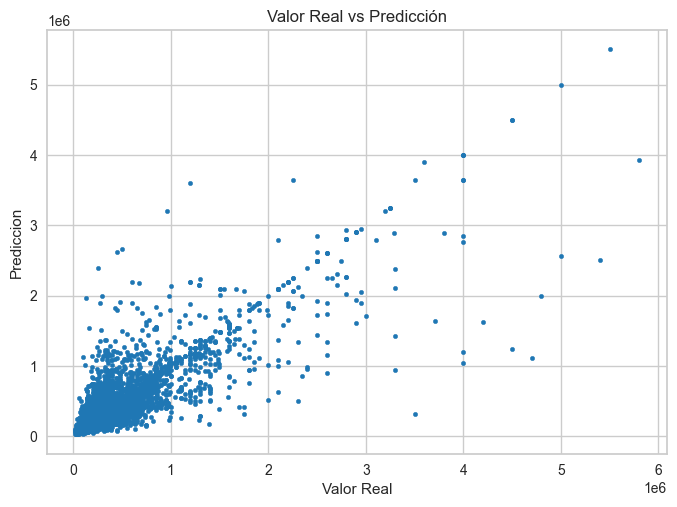

In [17]:
scatter_real_predict_test = performance_test.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


### Dataset con reducción de dimensionalidad:

#### Eleccion de variables regresoras

Como en el parte 1 ya limpiamos los valores atípicos no tenemos que hacerlo nuevamente para esta parte.

In [173]:
"""paiplot_dataset_procesado_con_reduccion_pca= sns.pairplot(pca_df).figure
paiplot_dataset_procesado_con_reduccion_pca.savefig('./Figures/paiplot_dataset_procesado_con_reduccion_pca')"""

"paiplot_dataset_procesado_con_reduccion_pca= sns.pairplot(pca_df).figure\npaiplot_dataset_procesado_con_reduccion_pca.savefig('./Figures/paiplot_dataset_procesado_con_reduccion_pca')"

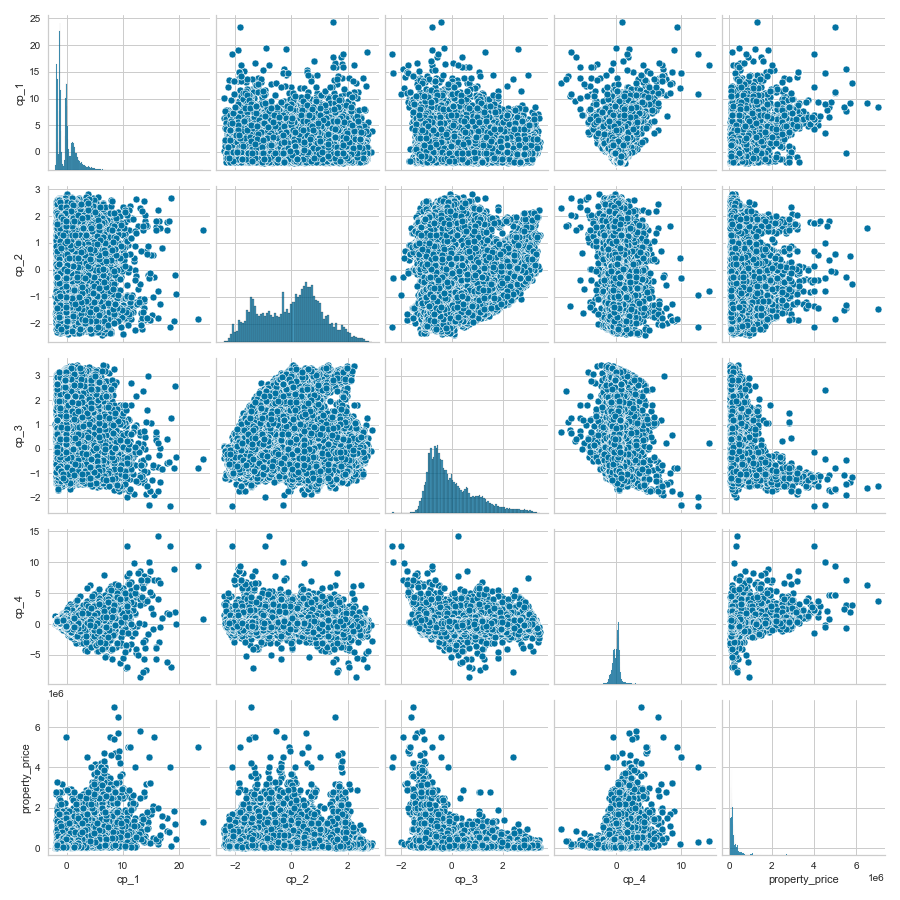

In [174]:
Image(filename = './Figures/paiplot_dataset_procesado_con_reduccion_pca.png', width=1000, height=1000)

In [18]:
#Heatmap correlación
pca_df.corr().style.background_gradient(cmap='coolwarm')

,cp_1,cp_2,cp_3,cp_4,property_price
cp_1,1.000000,-0.000002,0.000004,0.000001,0.637755
cp_2,-0.000002,1.000000,0.000013,-0.000004,-0.043645
cp_3,0.000004,0.000013,1.000000,0.000002,-0.230230
cp_4,0.000001,-0.000004,0.000002,1.000000,0.299823
property_price,0.637755,-0.043645,-0.230230,0.299823,1.000000


**Correlación**

Gracias al pairplot y a la matriz de correlacion vemos que el precio está más relacionado con la primera componente principal, seguida por la cuarta, por lo que las elegimos como variables regresoras (luego nos dimos cuenta que al usar las 4 CP mejoran las méticas).

In [19]:
#selecciono variables regresoras y a predecir
X_knn_pca = pca_df[['cp_1','cp_2','cp_3', 'cp_4']]
y_knn_pca = pca_df.property_price

#Separacion Train/test  (80/20)
X_train_knn_pca, X_test_knn_pca, y_train_knn_pca, y_test_knn_pca = train_test_split(X_knn_pca, y_knn_pca, test_size= 0.2, random_state=12)

In [20]:
#Heatmap correlación
X_train_knn_pca.corr().style.background_gradient(cmap='coolwarm')

,cp_1,cp_2,cp_3,cp_4
cp_1,1.000000,0.000564,0.001841,0.003735
cp_2,0.000564,1.000000,-0.000772,-0.000748
cp_3,0.001841,-0.000772,1.000000,0.001134
cp_4,0.003735,-0.000748,0.001134,1.000000


<AxesSubplot:xlabel='cp_1', ylabel='property_price'>

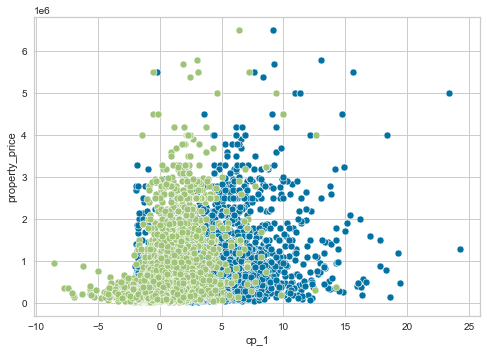

In [178]:
sns.scatterplot(x=X_train_knn_pca.cp_1,y=y_train_knn_pca)
sns.scatterplot(x=X_train_knn_pca.cp_4,y=y_train_knn_pca)

#### Ingeniería de características

**Normalizado de datos**

Decidimos no normalizar ya que empeoraban levemente nuestras métricas.

In [179]:
"""sc = StandardScaler()
#scalling the training set
X_train_knn_pca = sc.fit_transform(X_train_knn_pca)
#scalling the test set
X_test_knn_pca = sc.fit_transform(X_test_knn_pca)"""

'sc = StandardScaler()\n#scalling the training set\nX_train_knn_pca = sc.fit_transform(X_train_knn_pca)\n#scalling the test set\nX_test_knn_pca = sc.fit_transform(X_test_knn_pca)'

In [180]:
"""from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
X_train_knn_pca = scaler.fit_transform(X_train_knn_pca)
X_test_knn_pca = scaler.fit_transform(X_test_knn_pca)"""

'from sklearn.preprocessing import MinMaxScaler\n\nscaler = MinMaxScaler() \nX_train_knn_pca = scaler.fit_transform(X_train_knn_pca)\nX_test_knn_pca = scaler.fit_transform(X_test_knn_pca)'

**Optimizamos los parámetros usando Random Search Cross Validation**

In [21]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn_regressor_pca=KNeighborsRegressor()

#Random Search con 5 Folds y 5 iteraciones
rand_knn_pca = RandomizedSearchCV(knn_regressor_pca, params_grid, cv=5, scoring='r2', n_iter=5, random_state=5)

rand_knn_pca.fit(X_train_knn_pca, y_train_knn_pca)
rand_knn_pca.cv_results_['mean_test_score']

array([0.74292535, 0.68205305, 0.74602256, 0.72432165, 0.72735516])

In [22]:
#Mejores hiperparametros
print(rand_knn_pca.best_params_)
#Mejor métrica
print(rand_knn_pca.best_score_)

{'weights': 'distance', 'n_neighbors': 27, 'metric': 'euclidean', 'algorithm': 'kd_tree'}
0.7460225617096046


#### Métricas sobre train

In [23]:
#Mejor estimador
best_knn_regressor_pca = rand_knn_pca.best_estimator_

#Predicción con mejor estimador
y_pred_train_knn_pca = best_knn_regressor_pca.predict(X_train_knn_pca)

#Coef. de Determinación R2
r2_score_train_knn_pca = r2_score(y_train_knn_pca, y_pred_train_knn_pca)
print(f'Coef. de Determinación R2: {r2_score_train_knn_pca}')

#Coef. de Determinación R2 ajustado
n = X_train_knn_pca.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_train_knn_pca)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_train_knn_pca,
        y_pred  = y_pred_train_knn_pca,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_train_knn_pca,
        y_pred  = y_pred_train_knn_pca,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9688656685920565
Coef. de Determinación R2 ajustado: 0.9688639923601512
El error (mse) de test es: 2737646593.0805774
El error (rmse) de test es: 52322.524720053196


In [24]:
# Performance
performance_train_knn_pca = pd.DataFrame({'Valor Real': y_train_knn_pca,
                            'Prediccion': y_pred_train_knn_pca.round(),
                            'Error': y_train_knn_pca - y_pred_train_knn_pca.round()})
# View
performance_train_knn_pca.head()

,Valor Real,Prediccion,Error
59523,89000.0,89000.0,0.0
76456,140000.0,140000.0,0.0
26920,290000.0,239500.0,50500.0
27840,89000.0,89000.0,0.0
20164,650000.0,707500.0,-57500.0


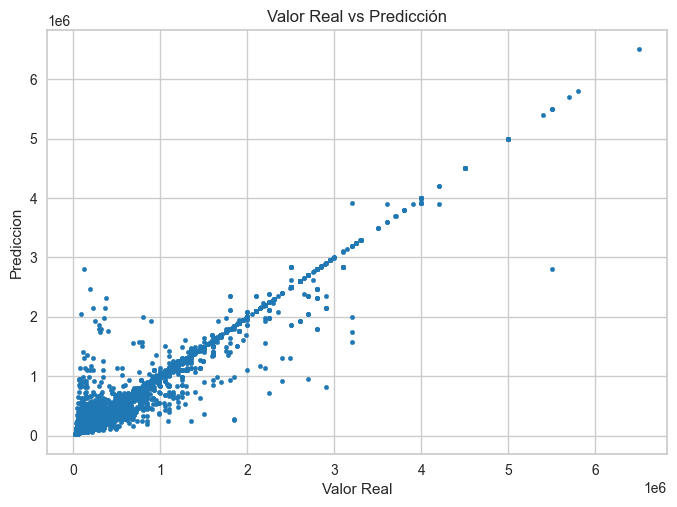

In [25]:
scatter_real_predict_train = performance_train_knn_pca.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


#### Métricas sobre test 

In [26]:
#Predicción con mejor estimador
y_pred_test_knn_pca = best_knn_regressor_pca.predict(X_test_knn_pca)

#Coef. de Determinación R2
r2_score_test_knn_pca = r2_score(y_test_knn_pca, y_pred_test_knn_pca)
print(f'Coef. de Determinación R2: {r2_score_test_knn_pca}')

#Coef. de Determinación R2 ajustado
n = X_test_knn_pca.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_knn_pca)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_knn_pca,
        y_pred  = y_pred_test_knn_pca,
        squared = True
       )
print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_knn_pca,
        y_pred  = y_pred_test_knn_pca,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.7605436734406072
Coef. de Determinación R2 ajustado: 0.7604920970415853
El error (mse) de test es: 21843147203.87067
El error (rmse) de test es: 147794.27324450252


In [27]:
# Performance
performance_test_knn_pca = pd.DataFrame({'Valor Real': y_test_knn_pca,
                            'Prediccion': y_pred_test_knn_pca.round(),
                            'Error': y_test_knn_pca - y_pred_test_knn_pca.round()})
# View
performance_test_knn_pca.head()

,Valor Real,Prediccion,Error
53374,85000.0,112764.0,-27764.0
897,289000.0,198263.0,90737.0
41973,235000.0,196108.0,38892.0
20322,92000.0,172607.0,-80607.0
84681,129000.0,205646.0,-76646.0


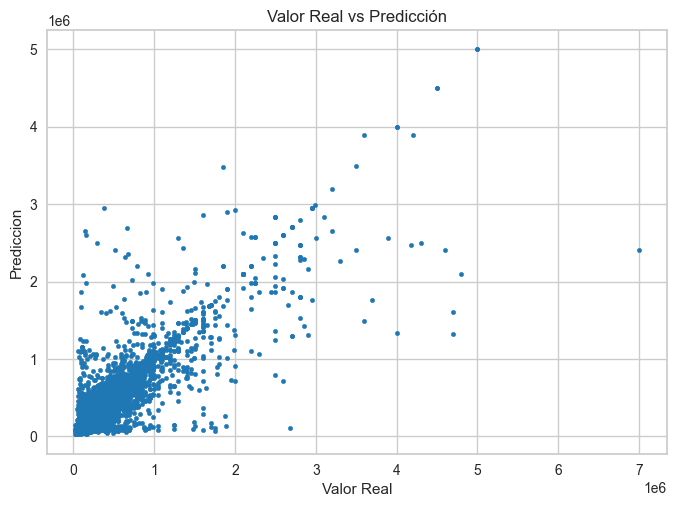

In [28]:
scatter_real_predict_test = performance_test_knn_pca.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


### Conclusiones KNN


Utilizamos 5 folds porque no obtuvimos mejoras al utilizar mayor cantidad.

Observamos que los resultados sobre el dataset original fueron casi idénticos (en cuanto a métricas) con los del dataset con reducción pca.



+ Coeficiente de determinación 𝑹^𝟐: me dice cuanto explica la variabilidad del problema (0 explica poco, 1 explica mucho).
+ Coeficiente de determinación 𝑹^𝟐 ajustado: similar a 𝑹^𝟐 solo que penaliza x la cantidad de variables incluidas en el modelo.
+ MSE:(Error Cuadrático Medio (Mean Squared Error)): Medida de qué tan cercana es la recta de regresión a los puntos que representan los datos. Mientras más chico más cerca está nuestro modelo de los datos reales. Al ser un valor elevado al cuadrado, es sensible a valores de diferencias grandes.
+ RMSE: es la raíz cuadrada de MSE, es mas fácil de interpretar ya que estará en las mismas unidades (dólares) que las del problema.


## Modelo 2: XGBoost

### https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

In [29]:
#selecciono variables regresoras y a predecir
x_train = viviendas_caba_train[['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']]
x_test = viviendas_caba_test[['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']]

y_train = viviendas_caba_train.property_price
y_test = viviendas_caba_test.property_price

In [30]:
#Creo el modelo y lo entreno

import xgboost as xgb
xgbr = xgb.XGBRegressor(verbosity=0, random_state=0)

xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [31]:
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

Training score:  0.861329099630668


In [46]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=6, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.73


In [47]:
from sklearn.metrics import mean_squared_error
y_pred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))


#Coef. de Determinación R2
r2_score = metrics.r2_score(y_test, y_pred)
print(f'Coef. de Determinación R2: {r2_score}')

MSE: 23899337000.56
RMSE: 154594.10
Coef. de Determinación R2: 0.7444511822835793


In [48]:
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred.round(),
                            'Error': y_test - y_pred.round()})
# View
performance.head()

,Valor Real,Prediccion,Error
0,140000.0,111519.0,28481.0
1,69900.0,124670.0,-54770.0
2,75900.0,72588.0,3312.0
3,315000.0,176398.0,138602.0
4,79000.0,77880.0,1120.0


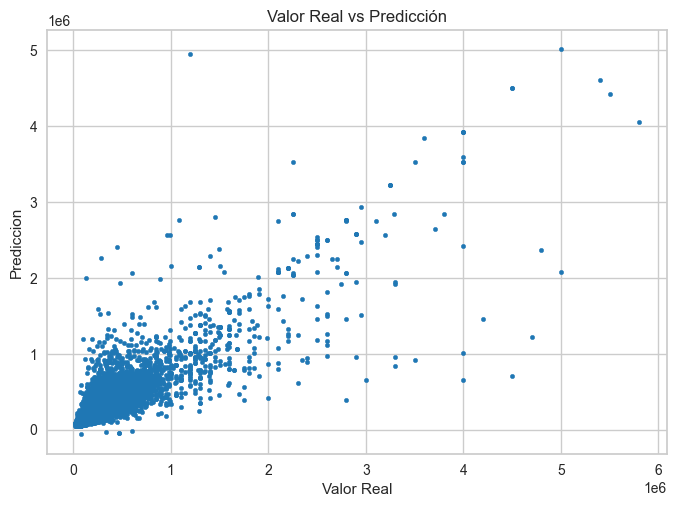

In [49]:
scatter = performance.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 

### Conclusiones XGBoost Train

Utilizamos 6 folds porque no obtuvimos mejoras al utilizar una mayor cantidad y al utilizar una menor, perdia la precisión. 

Observamos que los resultados obtenidos no son del todo buenos, ya que si bien son similares a los de KNN, tienen una menor precisión. Lo podemos verificar en los datos de MSE, RMSE y coeficiente de determinacion R2. 

Procederemos a analizar los datos con otro metodo nuevo y comparar cual es el mas preciso.


## Modelo 3: ADABoost

In [73]:
#selecciono variables regresoras y a predecir
x_train_ADA = viviendas_caba_train[['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']]
x_test_ADA = viviendas_caba_test[['property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']]


y_train_ADA = viviendas_caba_train.property_price
y_test_ADA = viviendas_caba_test.property_price

<class 'pandas.core.frame.DataFrame'>


In [62]:
from sklearn.ensemble import AdaBoostClassifier

ab_model = AdaBoostClassifier(n_estimators=10, random_state=0)
ab_model.fit(x_train_ADA, y_train_ADA)

AdaBoostClassifier(n_estimators=10, random_state=0)

In [ ]:
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

# Grafico el primer STUMP
dot_data = StringIO()
export_graphviz(ab_model.estimators_[0], out_file=dot_data,   filled=True, rounded=True,
                special_characters=True,feature_names=x_train_ADA.columns.to_list(),class_names=['No','Yes']) #VER ACA FEATURES

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

#Evalúo en el set de test

#AUC
y_pred_proba= ab_model.predict_proba(x_test_ADA)[:, 1]
print ('AUC:', roc_auc_score(y_test_ADA, y_pred_proba))

#Matriz Confusión
y_pred=ab_model.predict(x_test_ADA)
cm = confusion_matrix(y_test_ADA,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
#Reporte
print(classification_report(y_test_ADA,y_pred))